Starting EP for Student-t Process Classification...
n_samples=202, v=5.0, t=1.0096618357487923, v_bar=206.0
1.000001
0.8643874788930194
0.1426181955262621
0.17925905425713548
0.19849282150162104
0.12770022879938353
0.0889340746387763
0.4310565683491101
0.36979969145688374
0.03423925338482388
0.08213944497993778
0.12501748663718681
0.04198852461887946
0.052259017813528014
0.12225481432566042
0.31017328905857355
0.055433429523093124
0.3160751049949197
0.06095875431450713
0.05696205518888377
0.06464304231193711
0.07291216334619037
0.0767480836113684
0.41266136450740065
0.05090511366785158
0.051675955708513986
0.048913634907215106
0.051604908971630725
0.04986606421342068
0.044403933812076975
0.04860615867207572
0.048698062397878286
0.03839352358960072
0.07643020009154672
0.04010302760487276
0.06030339921263555
0.03797487443784433
0.028937427248402148
0.05046633873744856
0.06530151531152348
0.05659057805079968
0.04609088024208959
0.24886983829084197
0.05768796590717247
0.059504168366841005


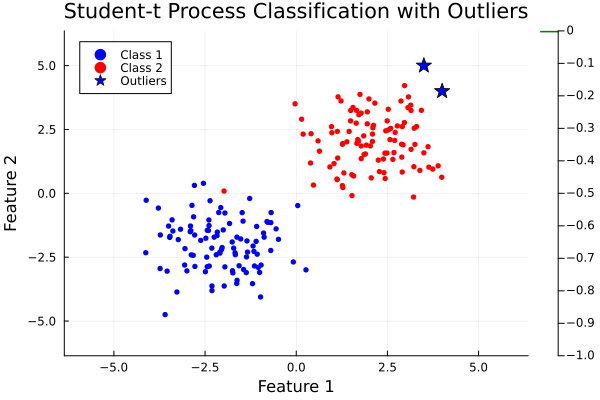

In [7]:
# --- 1. SETUP: Import libraries and define all functions/types ---
using LinearAlgebra, Distributions, SpecialFunctions
using Plots
using Random

# Global constant for the likelihood function
const LIKELIHOOD_EPSILON = 1e-6

# Define the RBF kernel function
function rbf_kernel(x1::AbstractMatrix, x2::AbstractMatrix, length_scale::Real)
    sq_dist = sum(x1.^2, dims=1)' .- 2 * (x1' * x2) .+ sum(x2.^2, dims=1)
    return exp.(-0.5 .* sq_dist ./ length_scale^2)
end

# Define the Classifier's data structure
mutable struct StudentTProcessClassifier
    v::Float64
    length_scale::Float64
    X_train::Matrix{Float64}
    y_train::Vector{Float64}
    μ::Vector{Float64}
    Σ::Matrix{Float64}
    τ_tilde::Vector{Float64}
    ν_tilde::Vector{Float64}
    t::Float64
    v_bar::Float64
end

# Define the constructor for the classifier
function StudentTProcessClassifier(; v::Real=10.0, length_scale::Real=1.0)
    return StudentTProcessClassifier(
        Float64(v), Float64(length_scale),
        zeros(0, 0), zeros(0), zeros(0), zeros(0, 0),
        zeros(0), zeros(0), 0.0, 0.0
    )
end

# Define the training function with the bug fix
function fit!(
    classifier::StudentTProcessClassifier,
    X::AbstractMatrix,
    y::AbstractVector;
    max_iters::Int=20,
    tol::Float64=1e-6
)
    # --- FIX IS HERE ---
    # The input matrix X should have dimensions (features, samples).
    n_features, n_samples = size(X)
    # --- END FIX ---

    k = n_samples # Notation from paper
    
    classifier.X_train = X
    classifier.y_train = y
    classifier.t = 1.0 + 2.0 / (classifier.v + k)
    classifier.v_bar = (classifier.v + k) - 1.0

    K_prior = rbf_kernel(X, X, classifier.length_scale)
    K_prior += 1e-6 * I
    classifier.Σ = K_prior
    classifier.μ = zeros(n_samples)
    classifier.τ_tilde = zeros(n_samples)
    classifier.ν_tilde = zeros(n_samples)

    println("Starting EP for Student-t Process Classification...")
    println("n_samples=$n_samples, v=$(classifier.v), t=$(classifier.t), v_bar=$(classifier.v_bar)")

    for iter in 1:max_iters
        μ_old = copy(classifier.μ)
        
        for i in 1:n_samples
            σ_i_sq = max(classifier.Σ[i, i], 1e-9)

            println(classifier.Σ[i, i])

            μ_i = classifier.μ[i]
            σ_prime_i_sq = σ_i_sq * classifier.v / classifier.v_bar
            τ_minus_i = (1.0 / σ_prime_i_sq) - classifier.τ_tilde[i]
            ν_minus_i = (μ_i / σ_prime_i_sq) - classifier.ν_tilde[i]
            τ_minus_i = max(τ_minus_i, 1e-9)
            σ_minus_i_sq = 1.0 / τ_minus_i
            μ_minus_i = ν_minus_i * σ_minus_i_sq
            z = y[i] * μ_minus_i / sqrt(σ_minus_i_sq)
            student_t_dist = TDist(classifier.v_bar)
            Z1 = (1 - LIKELIHOOD_EPSILON) * cdf(student_t_dist, z) + LIKELIHOOD_EPSILON
            Z2 = (1 - LIKELIHOOD_EPSILON) * cdf(TDist(classifier.v_bar + 2), z) + LIKELIHOOD_EPSILON
            Z1 = max(Z1, 1e-9); Z2 = max(Z2, 1e-9)
            r = Z1 / Z2
            α = y[i] * ((1 - LIKELIHOOD_EPSILON) * pdf(student_t_dist, z)) / (Z2 * sqrt(σ_minus_i_sq))
            μ_hat_i = μ_minus_i + α * σ_minus_i_sq
            σ_hat_i_sq = σ_minus_i_sq * (r - α * μ_hat_i)
            Δτ = (1.0 / max(σ_hat_i_sq, 1e-9)) - τ_minus_i - classifier.τ_tilde[i]
            Δν = (μ_hat_i / max(σ_hat_i_sq, 1e-9)) - ν_minus_i - classifier.ν_tilde[i]
            damping = 0.5
            classifier.τ_tilde[i] += damping * Δτ
            classifier.ν_tilde[i] += damping * Δν
            s_i = classifier.Σ[:, i]
            classifier.Σ -= (s_i * s_i') ./ (1.0 / (damping * Δτ) + s_i[i])
            classifier.μ = classifier.Σ * classifier.ν_tilde
        end
        
        diff = norm(classifier.μ - μ_old) / (norm(μ_old) + 1e-9)
        if iter % 5 == 0 println("Iter $iter: Change in μ = $diff") end
        if diff < tol
            println("Converged at iteration $iter.")
            break
        end
        if iter == max_iters println("Warning: Reached max iterations without convergence.") end
    end
    return classifier
end

# Define the prediction function
function predict(classifier::StudentTProcessClassifier, X_star::AbstractMatrix)
    if isempty(classifier.X_train) error("Classifier has not been trained. Call `fit!` first.") end
    K_star = rbf_kernel(classifier.X_train, X_star, classifier.length_scale)
    v = classifier.Σ \ classifier.μ
    predictive_mean = K_star' * v

    println("Predictive mean: ", predictive_mean)

    return sign.(predictive_mean)
end


# --- 2. USAGE: Generate data, train the model, and plot the results ---

Random.seed!(42)
n = 100
X1 = randn(n, 2) .+ [-2, -2]'
y1 = fill(1.0, n)
X2 = randn(n, 2) .+ [2, 2]'
y2 = fill(-1.0, n)
outliers = [4.0 4.0; 3.5 5.0]
y_outliers = fill(1.0, 2)
X = vcat(X1, X2, outliers)
y = vcat(y1, y2, y_outliers)

# Train the Classifier
stp_classifier = StudentTProcessClassifier(v=5.0, length_scale=2.0)
# Pass the transpose of X, so the input to fit! is (features, samples)
fit!(stp_classifier, X', y, max_iters=25)

# Visualize the Decision Boundary
println("Generating plot...")
x_range = -6:0.2:6
y_range = -6:0.2:6
grid = hcat([[i, j] for i in x_range for j in y_range]...)
# The predict function also expects (features, samples)
grid_preds = predict(stp_classifier, grid)
p = scatter(X1[:,1], X1[:,2], label="Class 1", color=:blue, markersize=3, markerstrokewidth=0)
scatter!(p, X2[:,1], X2[:,2], label="Class 2", color=:red, markersize=3, markerstrokewidth=0)
scatter!(p, outliers[:,1], outliers[:,2], label="Outliers", color=:blue, markershape=:star5, markersize=8)
contour!(p, x_range, y_range, reshape(grid_preds, length(x_range), length(y_range))',
         levels=[0], color=:green, linewidth=3, label="STP Boundary")
title!("Student-t Process Classification with Outliers")
xlabel!("Feature 1")
ylabel!("Feature 2")
display(p)

-3721.0

ErrorException: invalid redefinition of constant Main.StudentTProcessEP